# Стоимость автомобилей

Есть датасет с историческими данными: технические характеристики, комплектации и цены автомобилей. Нужно построить модель для определения стоимости. 

Заказчику важны:

- качество предсказания;
- скорость предсказания;
- время обучения.

## Подготовка данных

In [1]:
!pip install -q phik

In [2]:
import pandas as pd
import numpy as np
import sklearn as sk
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder, OrdinalEncoder, StandardScaler, MinMaxScaler, RobustScaler
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.metrics import roc_auc_score, make_scorer
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import Ridge
from sklearn.tree import DecisionTreeRegressor
from warnings import simplefilter
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import RandomizedSearchCV
import lightgbm as lgb
import warnings
from scipy.stats import randint, uniform
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score
from lightgbm import LGBMRegressor
import phik
import seaborn as sns
import matplotlib.pyplot as plt

In [3]:
warnings.filterwarnings("ignore")

In [4]:
autos_data = pd.read_csv('/datasets/autos.csv')

In [5]:
autos_data.head(40)

,DateCrawled,Price,VehicleType,RegistrationYear,Gearbox,Power,Model,Kilometer,RegistrationMonth,FuelType,Brand,Repaired,DateCreated,NumberOfPictures,PostalCode,LastSeen
0,2016-03-24 11:52:17,480,NaN,1993,manual,0,golf,150000,0,petrol,volkswagen,NaN,2016-03-24 00:00:00,0,70435,2016-04-07 03:16:57
1,2016-03-24 10:58:45,18300,coupe,2011,manual,190,NaN,125000,5,gasoline,audi,yes,2016-03-24 00:00:00,0,66954,2016-04-07 01:46:50
2,2016-03-14 12:52:21,9800,suv,2004,auto,163,grand,125000,8,gasoline,jeep,NaN,2016-03-14 00:00:00,0,90480,2016-04-05 12:47:46
3,2016-03-17 16:54:04,1500,small,2001,manual,75,golf,150000,6,petrol,volkswagen,no,2016-03-17 00:00:00,0,91074,2016-03-17 17:40:17
4,2016-03-31 17:25:20,3600,small,2008,manual,69,fabia,90000,7,gasoline,skoda,no,2016-03-31 00:00:00,0,60437,2016-04-06 10:17:21
5,2016-04-04 17:36:23,650,sedan,1995,manual,102,3er,150000,10,petrol,bmw,yes,2016-04-04 00:00:00,0,33775,2016-04-06 19:17:07
6,2016-04-01 20:48:51,2200,convertible,2004,manual,109,2_reihe,150000,8,petrol,peugeot,no,2016-04-01 00:00:00,0,67112,2016-04-05 18:18:39
7,2016-03-21 18:54:38,0,sedan,1980,manual,50,other,40000,7,petrol,volkswagen,no,2016-03-21 00:00:00,0,19348,2016-03-25 16:47:58
8,2016-04-04 23:42:13,14500,bus,2014,manual,125,c_max,30000,8,petrol,ford,NaN,2016-04-04 00:00:00,0,94505,2016-04-04 23:42:13
9,2016-03-17 10:53:50,999,small,1998,manual,101,golf,150000,0,NaN,volkswagen,NaN,2016-03-17 00:00:00,0,27472,2016-03-31 17:17:06


In [6]:
autos_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 354369 entries, 0 to 354368
Data columns (total 16 columns):
 #   Column             Non-Null Count   Dtype 
---  ------             --------------   ----- 
 0   DateCrawled        354369 non-null  object
 1   Price              354369 non-null  int64 
 2   VehicleType        316879 non-null  object
 3   RegistrationYear   354369 non-null  int64 
 4   Gearbox            334536 non-null  object
 5   Power              354369 non-null  int64 
 6   Model              334664 non-null  object
 7   Kilometer          354369 non-null  int64 
 8   RegistrationMonth  354369 non-null  int64 
 9   FuelType           321474 non-null  object
 10  Brand              354369 non-null  object
 11  Repaired           283215 non-null  object
 12  DateCreated        354369 non-null  object
 13  NumberOfPictures   354369 non-null  int64 
 14  PostalCode         354369 non-null  int64 
 15  LastSeen           354369 non-null  object
dtypes: int64(7), object(

In [7]:
autos_data.columns = autos_data.columns.str.lower()
autos_data = autos_data.rename(columns={'datecrawled':'date_crawled', 
                        'vehicletype':'vehicle_type', 
                        'registrationyear':'registration_year', 
                        'registrationmonth':'registration_month', 
                        'fueltype':'fuel_type', 
                        'notrepaired':'not_repaired', 
                        'datecreated':'date_created',
                        'numberofpictures': 'number_of_pictures',
                        'postalcode':'postal_code',
                        'lastseen':'last_seen'})

Удалю неинформативные стобцы:

In [8]:
autos_data = autos_data.drop(['date_crawled', 'date_created', 'number_of_pictures', 'postal_code', 'last_seen'], axis=1)

gasoline и petrol - это одно и то же, заменю соответствующие значения в колонке fuel_type

In [9]:
autos_data['fuel_type'] = autos_data['fuel_type'].replace(['petrol'], 'gasoline')

In [10]:
autos_data.isna().sum()

price                     0
vehicle_type          37490
registration_year         0
gearbox               19833
power                     0
model                 19705
kilometer                 0
registration_month        0
fuel_type             32895
brand                     0
repaired              71154
dtype: int64

В данных очень много пропусков, в столбце repaired лучше всего будет заменить пропущенные значения на "no", в остальных заменю на "unknown"

In [11]:
autos_data['repaired'].fillna('no', inplace=True)

In [12]:
autos_data.fillna('unknown', inplace=True)

In [13]:
autos_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 354369 entries, 0 to 354368
Data columns (total 11 columns):
 #   Column              Non-Null Count   Dtype 
---  ------              --------------   ----- 
 0   price               354369 non-null  int64 
 1   vehicle_type        354369 non-null  object
 2   registration_year   354369 non-null  int64 
 3   gearbox             354369 non-null  object
 4   power               354369 non-null  int64 
 5   model               354369 non-null  object
 6   kilometer           354369 non-null  int64 
 7   registration_month  354369 non-null  int64 
 8   fuel_type           354369 non-null  object
 9   brand               354369 non-null  object
 10  repaired            354369 non-null  object
dtypes: int64(5), object(6)
memory usage: 29.7+ MB


Типы данных расставлены верно.

In [14]:
autos_data.describe()

,price,registration_year,power,kilometer,registration_month
count,354369.000000,354369.000000,354369.000000,354369.000000,354369.000000
mean,4416.656776,2004.234448,110.094337,128211.172535,5.714645
std,4514.158514,90.227958,189.850405,37905.341530,3.726421
min,0.000000,1000.000000,0.000000,5000.000000,0.000000
25%,1050.000000,1999.000000,69.000000,125000.000000,3.000000
50%,2700.000000,2003.000000,105.000000,150000.000000,6.000000
75%,6400.000000,2008.000000,143.000000,150000.000000,9.000000
max,20000.000000,9999.000000,20000.000000,150000.000000,12.000000


In [15]:
for i in ['price', 'registration_year', 'power', 'kilometer']:
    print(i)
    print(autos_data[i].unique())
    print()

price
[  480 18300  9800 ... 12395 18429 10985]

registration_year
[1993 2011 2004 2001 2008 1995 1980 2014 1998 2005 1910 2016 2007 2009
 2002 2018 1997 1990 2017 1981 2003 1994 1991 1984 2006 1999 2012 2010
 2000 1992 2013 1996 1985 1989 2015 1982 1976 1983 1973 1111 1969 1971
 1987 1986 1988 1970 1965 1945 1925 1974 1979 1955 1978 1972 1968 1977
 1961 1960 1966 1975 1963 1964 5000 1954 1958 1967 1959 9999 1956 3200
 1000 1941 8888 1500 2200 4100 1962 1929 1957 1940 3000 2066 1949 2019
 1937 1951 1800 1953 1234 8000 5300 9000 2900 6000 5900 5911 1933 1400
 1950 4000 1948 1952 1200 8500 1932 1255 3700 3800 4800 1942 7000 1935
 1936 6500 1923 2290 2500 1930 1001 9450 1944 1943 1934 1938 1688 2800
 1253 1928 1919 5555 5600 1600 2222 1039 9996 1300 8455 1931 1915 4500
 1920 1602 7800 9229 1947 1927 7100 8200 1946 7500 3500]

power
[    0   190   163    75    69   102   109    50   125   101   105   140
   115   131    60   136   160   231    90   118   193    99   113   218
   122   129 

Поработаю с аномальными значениями:

In [16]:
autos_data = autos_data.query('price > 0')
autos_data = autos_data.query('(registration_year < 2016) or ((registration_year == 2016) and (registration_month < 4))')
autos_data = autos_data.query('(power > 0) & (power < 1000)')


In [17]:
autos_data = autos_data.drop(['registration_month'], axis=1)

***Вывод***

Обработаны пропуски, аномалии в данных, удалены ненужные столбцы - данные подготовлены.

## Обучение моделей

Разделю данные на выборки и обучу три модели: DecisionTreeRegressor, Ridge, LightGBM:

In [18]:
autos_data.head()

,price,vehicle_type,registration_year,gearbox,power,model,kilometer,fuel_type,brand,repaired
1,18300,coupe,2011,manual,190,unknown,125000,gasoline,audi,yes
2,9800,suv,2004,auto,163,grand,125000,gasoline,jeep,no
3,1500,small,2001,manual,75,golf,150000,gasoline,volkswagen,no
4,3600,small,2008,manual,69,fabia,90000,gasoline,skoda,no
5,650,sedan,1995,manual,102,3er,150000,gasoline,bmw,yes


Разделю данные по выборкам:

In [19]:
RANDOM_STATE = 42
X = autos_data.drop(columns=['price'])
y = autos_data['price']
X_train, X_test, y_train, y_test = train_test_split(X, 
                                    y, 
                                    random_state=RANDOM_STATE)

Составлю списки признаков и создам нужные пайплайны:

In [20]:
num_features = ['registration_year', 'power', 'kilometer']
cat_features_ohe = ['vehicle_type', 'gearbox', 'model', 'brand', 'fuel_type']
cat_features_ord = ['repaired']

In [21]:
num_transformer = Pipeline([
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler())
])

cat_transformer_ohe = Pipeline([
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('encoder', OneHotEncoder(handle_unknown='error', drop='first'))
])

cat_transformer_ord = Pipeline([
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('encoder', OrdinalEncoder(handle_unknown='use_encoded_value', unknown_value=np.nan, categories=[['no', 'yes']]))
])

In [22]:
preprocessor = ColumnTransformer([
    ('num', num_transformer, num_features),
    ('cat_ohe', cat_transformer_ohe, cat_features_ohe),
    ('cat_ord', cat_transformer_ord, cat_features_ord)],
    remainder='passthrough')

Создам три пайплайна с моделями и три словаря гиперпараметров для каждой

In [23]:
tree_reg = Pipeline([
    ('preprocessor', preprocessor),
    ('model', DecisionTreeRegressor(random_state=RANDOM_STATE))
])

ridge_reg = Pipeline([
    ('preprocessor', preprocessor),
    ('model', Ridge())
])

lgb_pipe = Pipeline([
    ('preprocessor', preprocessor),
    ('model', LGBMRegressor(random_state=RANDOM_STATE))
])

param_grid = {
    'model__max_depth': [3, 5, 7, 10, 15, None],
    'model__min_samples_split': randint(2, 11),
    'model__min_samples_leaf': randint(1, 6),
    'model__ccp_alpha': uniform(0.0, 0.05)
}

param_grid_1 = {
    'model__alpha': uniform(0.0, 10.0),
    'model__fit_intercept': [True, False],
    'model__copy_X': [True, False]
}

param_grid_2 = {
    'model__num_leaves': randint(20, 150),
    'model__max_depth': randint(3, 12),
    'model__learning_rate': uniform(0.01, 0.29)
}

Проведу кросс-валидацию трех моделей и получу результаты:

In [24]:
random_search = RandomizedSearchCV(
    tree_reg,
    param_distributions=param_grid,
    n_iter=5,        
    scoring='neg_root_mean_squared_error',
    cv=5,
    n_jobs=-1,
    random_state=42,
    verbose=1
)

In [25]:
random_search.fit(X_train, y_train)
best_model = random_search.best_estimator_

Fitting 5 folds for each of 5 candidates, totalling 25 fits


In [26]:
print('Время обучения модели:', random_search.cv_results_['mean_fit_time'][random_search.best_index_])
print('Время предсказания модели:', random_search.cv_results_['mean_score_time'][random_search.best_index_])

Время обучения модели: 12.613421201705933
Время предсказания модели: 0.10892210006713868


In [27]:
-random_search.best_score_

1750.8016239722087

DecisionTreeRegressor показал хороший результат RMSE = 1750, что уже подходит под критерий, что RMSE должно быть меньше 2500. Обучу другие модели.

In [28]:
random_search_1 = RandomizedSearchCV(
    ridge_reg,
    param_distributions=param_grid_1,
    n_iter=5,        
    scoring='neg_root_mean_squared_error',
    cv=5,
    n_jobs=-1,
    random_state=42,
    verbose=1
)

In [29]:
random_search_1.fit(X_train, y_train)
best_model_1 = random_search_1.best_estimator_

Fitting 5 folds for each of 5 candidates, totalling 25 fits


In [30]:
print('Время обучения модели:', random_search_1.cv_results_['mean_fit_time'][random_search_1.best_index_])
print('Время предсказания модели:', random_search_1.cv_results_['mean_score_time'][random_search_1.best_index_])

Время обучения модели: 0.7787051677703858
Время предсказания модели: 0.09259352684020997


In [31]:
-random_search_1.best_score_

2766.5246152866584

Ridge показал результаты хуже - RMSE = 2766, это значение слишком большое.

In [32]:
random_search_2 = RandomizedSearchCV(
    lgb_pipe,
    param_distributions=param_grid_2,
    n_iter=5,        
    scoring='neg_root_mean_squared_error',
    cv=5,
    n_jobs=-1,
    random_state=42,
    verbose=1
)

In [33]:
random_search_2.fit(X_train, y_train)
best_model_2 = random_search_2.best_estimator_

Fitting 5 folds for each of 5 candidates, totalling 25 fits


In [34]:
print('Время обучения модели:', random_search_2.cv_results_['mean_fit_time'][random_search_2.best_index_])
print('Время предсказания модели:', random_search_2.cv_results_['mean_score_time'][random_search_2.best_index_])

Время обучения модели: 6.725093650817871
Время предсказания модели: 0.4353339195251465


In [35]:
-random_search_2.best_score_

1605.7338476786658

Градиентный бустинг показал лучший из всех моделей RMSE - 1605.

***Вывод***

Данные были разделены на выборки, обработаны в пайплайне, после чего были обучены три модели: DecisionTreeRegressor, Ridge, LightGBM. Для каждой из них были подобраны гиперпараметры и проведена кросс-валидация, на следующем этапе я проанализирую время обучения и предсказания модели, а также RMSE.

## Анализ моделей

Время обучения моделей и их RMSE на кросс-валидации:

***DecisionTreeRegressor:*** 

RMSE: 1750

Время: Обучение ~ 12.7 s, предсказание ~ 0.1 s

***Ridge:***

RMSE: 2766

Время: Обучение ~ 0.8 s, предсказание ~ 0.1 s


***LightGBM:***

RMSE: 1605

Время: Обучение ~ 4.7 s, предсказание ~ 0.4 s

Лучший результат RMSE показал градиентный бустинг с большим отрывом от Ridge, также градиентный бустинг обучался почти в три раза меньше времени чем дерево решений. Лучшей моделью несомненно будет градиентный бустинг, проверю её качество на тестовой выборке.

In [36]:
y_predict_2 = best_model_2.predict(X_test)

In [37]:
mean_squared_error(y_test, y_predict_2) ** 0.5

1592.0754858210526

RMSE = 1592 - этот результат лучший из всех моделей.

Построю график реальных vs предсказанных значений, график остатков, а также посмотрю на корреляцию остатков и признаков.

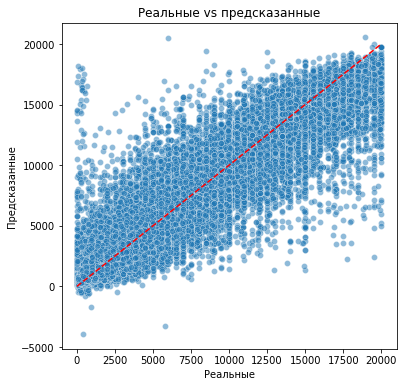

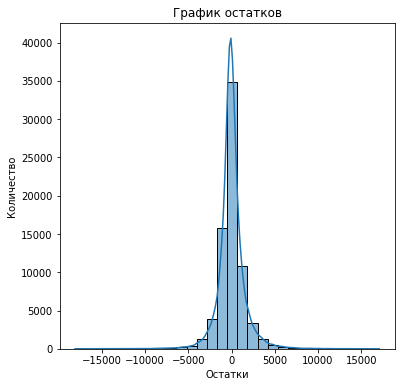

In [38]:
plt.figure(figsize=(6,6))
sns.scatterplot(x=y_test, y=y_predict_2, alpha=0.5)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--')
plt.xlabel('Реальные')
plt.ylabel('Предсказанные')
plt.title('Реальные vs предсказанные')
plt.show()

residuals = y_test - y_predict_2
plt.figure(figsize=(6,6))
sns.histplot(residuals, bins=30, kde=True)
plt.xlabel("Остатки")
plt.ylabel("Количество")
plt.title("График остатков")
plt.show()


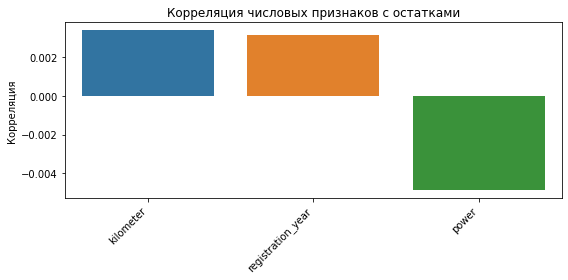

In [39]:
residuals = y_test - y_predict_2

df_res = X_test.copy()
df_res['residuals'] = residuals

correlations = df_res.corr()['residuals'].drop('residuals').sort_values(ascending=False)

plt.figure(figsize=(8, 4))
sns.barplot(x=correlations.index, y=correlations.values)
plt.xticks(rotation=45, ha='right')
plt.ylabel('Корреляция')
plt.title('Корреляция числовых признаков с остатками')
plt.tight_layout()
plt.show()


***Реальные vs предсказанные***

Точки расположены вдоль диагонали - это значит, что модель предсказывает близко к реальным значениям. Чем выше реальное значение - тем больше разброс предсказаний. Модель недооценивает дорогие автомобили и переоценивает дешевые - это иллюстрируется большим значением ниже и выше красной диагонали.

***Остатки***

Распределение остатков куполообразное, оно близко к нормальному, нет больших хвостов или смещений - все это говорит о хорошем качестве предсказаний.

***Корреляция числовых признаков с остатками***

Построив график корреляции числовых признаков с остатками можно сказать, что у ошибок модели нет выраженной зависимости с каким-то из признаков - значит, что все эти признаки модель не упустила из виду. 

In [40]:
r2_score(y_test, y_predict_2)

0.8808636683365096

R2 показал, что модель объясняет большую часть разброса целевой переменной.

***Общий вывод***

Данные были обработаны, после чего обучены три модели: DecisionTreeRegressor, Ridge, LightGBM.

Модели дали такие показатели:

***DecisionTreeRegressor:*** 

RMSE: 1750

Время: Обучение ~ 12.7 s, предсказание ~ 0.1 s

***Ridge:***

RMSE: 2766

Время: Обучение ~ 0.8 s, предсказание ~ 0.1 s


***LightGBM:***

RMSE: 1605

Время: Обучение ~ 4.7 s, предсказание ~ 0.4 s

Лучший результат RMSE показал градиентный бустинг с большим отрывом от Ridge, также градиентный бустинг обучался почти в три раза меньше времени чем дерево решений, время предсказания всех моделей меньше одной секунды. Лучшей моделью несомненно будет градиентный бустинг, проверю её качество на тестовой выборке.

Качество модели оценивалось с помощью RMSE, R2, а также графиках реальных vs предсказанных зачений, распределения остатков, а также корреляции числовых признаков с остатками.

***Реальные vs предсказанные***

Точки расположены вдоль диагонали - это значит, что модель предсказывает близко к реальным значениям. Чем выше реальное значение - тем больше разброс предсказаний. Модель недооценивает дорогие автомобили и переоценивает дешевые - это иллюстрируется большим значением ниже и выше красной диагонали.

***Остатки***

Распределение остатков куполообразное, оно близко к нормальному, нет больших хвостов или смещений - все это говорит о хорошем качестве предсказаний.

***Корреляция числовых признаков с остатками***

Построив график корреляции числовых признаков с остатками можно сказать, что у ошибок модели нет выраженной зависимости с каким-то из признаков - значит, что все эти признаки модель не упустила из виду. 


Модель хорошо справилась с задачей, показав на тестовой выборке RMSE = 1592, она подходит под критерии заказчика - она объединяет в себе хорошую точность и скорость.

Лучшая модель хранится в переменной best_model_2, а ее предсказания в переменной y_predict_2.